In [7]:
%%capture --no-stderr
print("This will be captured.")
raise ValueError("This error message will still be shown.")


ValueError: This error message will still be shown.

In [12]:
from typing_extensions import TypedDict
from typing import Literal



class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]


abs = TypedDictState({'name': 1, "mood": "sad"})
abs

{'name': 1, 'mood': 'sad'}

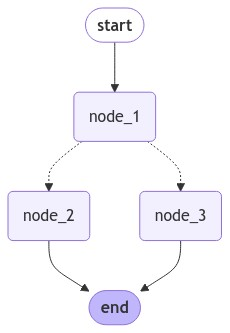

In [15]:

import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}


def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_node(state) -> Literal["node_2", "node_3"] :
    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_node)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# add
graph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"name": "lance"})

---Node 1---
---Node 3---


{'name': 'lance is ... ', 'mood': 'sad'}

In [18]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

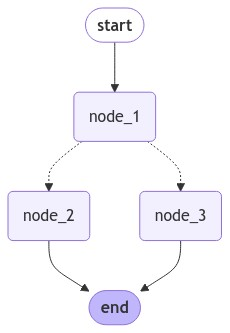

In [20]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_node)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
graph.invoke(DataclassState(name="Lance",mood="sad"))


---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

In [25]:
graph.invoke({"name": "lance", "mood": "sad", "age": 19})

---Node 1---
---Node 2---


{'name': 'lance is ... ', 'mood': 'happy'}

In [26]:
def my_decorator(func):
    def wrapper(*args, **kwargs):
        print("Before function call")
        result = func(*args, **kwargs)
        print("After function call")
        return result
    return wrapper

@my_decorator
def my_function():
    print("Inside my_function")

my_function()

Before function call
Inside my_function
After function call


In [29]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


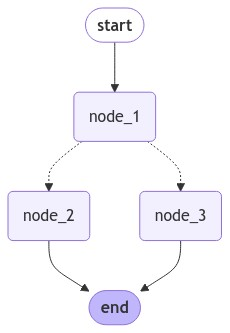

In [30]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_node)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph.invoke(PydanticState(name="Lance",mood="mad"))

### Understanding cache 

In [1]:
## In memory cache

In [2]:
from langchain.globals import set_llm_cache
from langchain_openai import OpenAI

# To make the caching really obvious, lets use a slower and older model.
# Caching supports newer chat models as well.
llm = OpenAI(model="gpt-3.5-turbo-instruct", n=2, best_of=2)

In [3]:
from langchain_community.cache import InMemoryCache

set_llm_cache(InMemoryCache())

In [4]:
%%time
# The first time, it is not yet in cache, so it should take longer
llm.invoke("Tell me a joke")

CPU times: total: 15.6 ms
Wall time: 1.25 s


"\n\nWhy couldn't the bicycle stand up by itself?\n\nBecause it was two-tired! "

In [5]:
%%time
# The second time it is, so it goes faster
llm.invoke("Tell me a joke")

CPU times: total: 0 ns
Wall time: 0 ns


"\n\nWhy couldn't the bicycle stand up by itself?\n\nBecause it was two-tired! "

In [6]:
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal,List
import operator


import os



from dotenv import load_dotenv
model_name = "gpt-4o"
load_dotenv(override=True)
llm = ChatOpenAI(model=model_name,
                             temperature=0,
                            max_tokens=None,
                            timeout=None,
                            max_retries=4)
#llm.invoke("Hello there !!"           )

In [1]:
from langchain.globals import set_llm_cache
from upstash_semantic_cache import SemanticCache

In [9]:
UPSTASH_VECTOR_REST_URL = "https://splendid-marlin-54950.upstash.io"
UPSTASH_VECTOR_REST_TOKEN = "AdamAAIjcDE4OTMwN2MyMWVmZTg0NTNkYWVjMmE2NmM4NGU4MzNkYnAxMA"

cache = SemanticCache(
    url=UPSTASH_VECTOR_REST_URL, token=UPSTASH_VECTOR_REST_TOKEN, min_proximity=0.7
)

set_llm_cache(cache)

In [10]:
%%time
llm.invoke("Which city is the most crowded city in the USA?")

UpstashError: ERR Command is not available: 'QUERY-DATA'. See https://upstash.com/docs/redis/overall/rediscompatibility for details

In [ ]:
%%time
llm.invoke("Which city has the highest population in the USA?")